<a href="https://colab.research.google.com/github/debapratimj/RL-with-LSNNs/blob/master/LSNN_STDP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install brian2
from brian2 import *
import numpy as np
#from scipy import sparse
#from scipy.integrate import odeint
import random
from time import perf_counter
#import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import math 
import pickle

     |████████████████████████████████| 1.6MB 3.4MB/s 
     |████████████████████████████████| 5.8MB 19.1MB/s 
  Created wheel for brian2: filename=Brian2-2.3.0.2-cp36-cp36m-linux_x86_64.whl size=1283456 sha256=46ea0d0d594de1bbc623468ab11578cbddb6c7857380e0c4ed1213687ee71c54
  Stored in directory: /root/.cache/pip/wheels/86/b5/f6/0c8f9eec58c01e4af55a4c79a5e0385aea01ed03e4ec36c4ac
Successfully built brian2
  Found existing installation: sympy 1.1.1
    Uninstalling sympy-1.1.1:
      Successfully uninstalled sympy-1.1.1




Running Training Epoch 1


Computation Time : 153.6876382339999 seconds


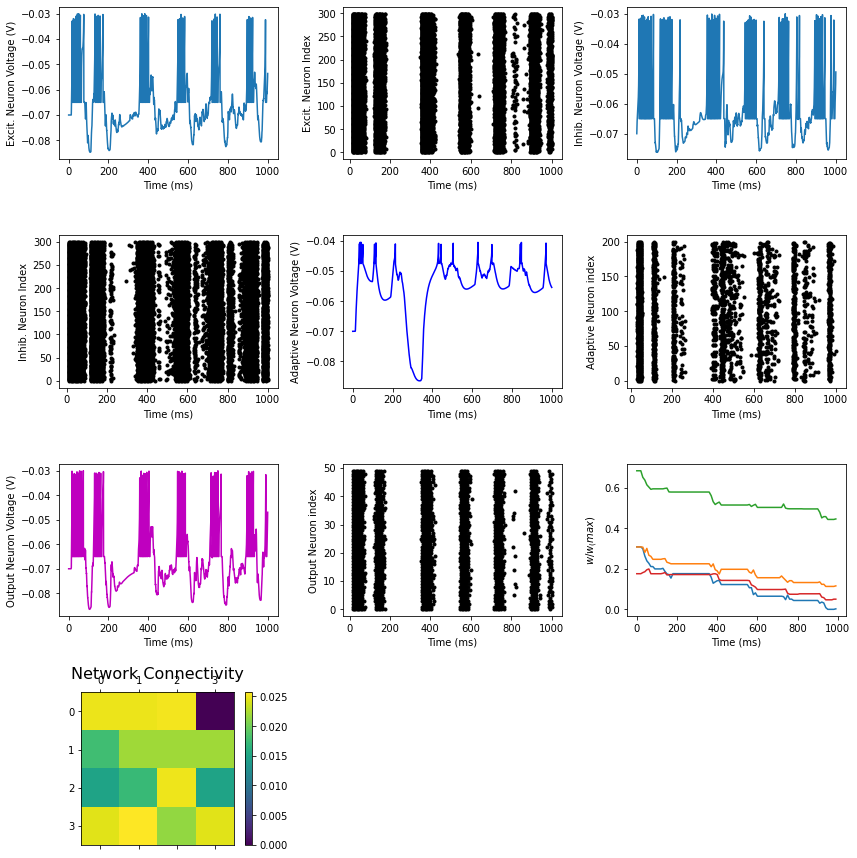

Running Training Epoch 2


Computation Time : 55.855215860000044 seconds


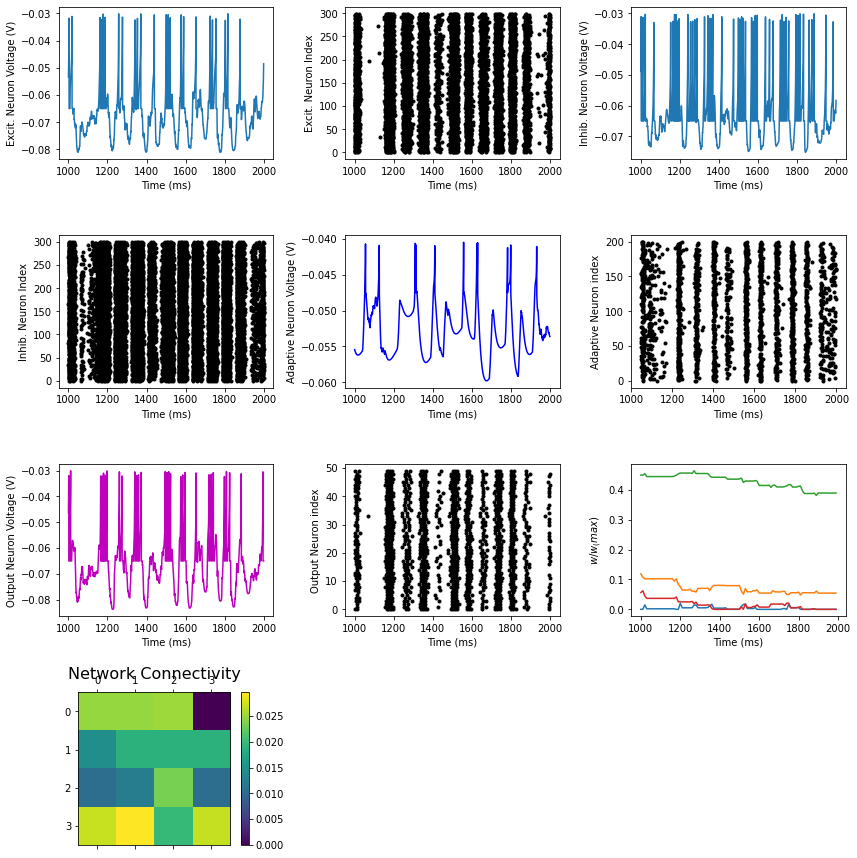

Running Training Epoch 3


Computation Time : 56.47817281099992 seconds


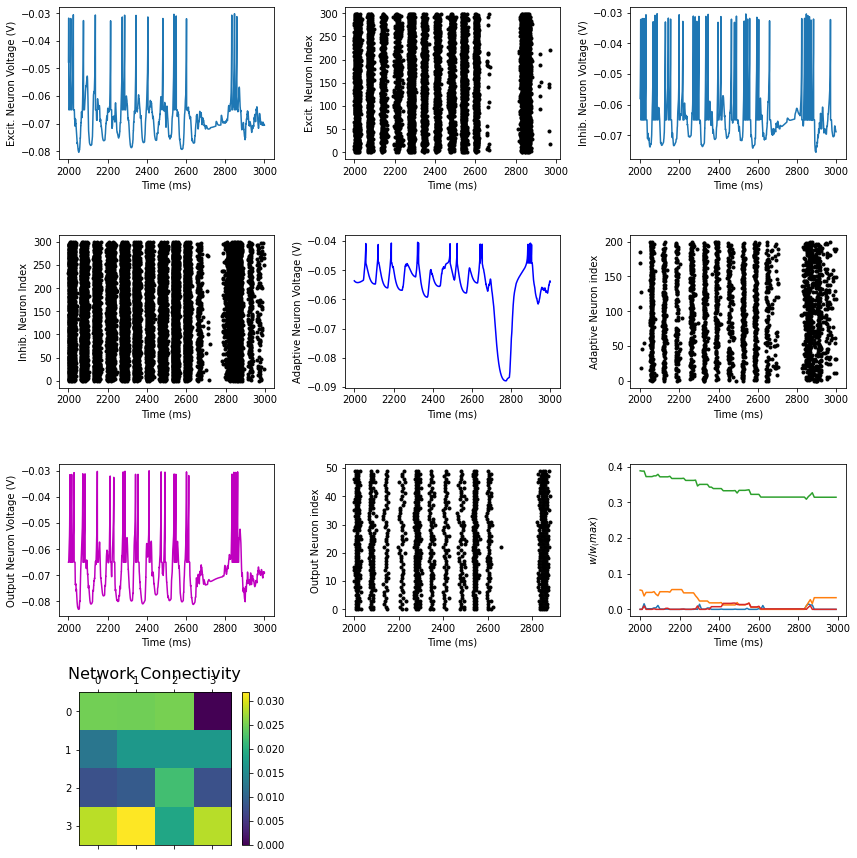

Running Training Epoch 4


Computation Time : 57.47976993099974 seconds


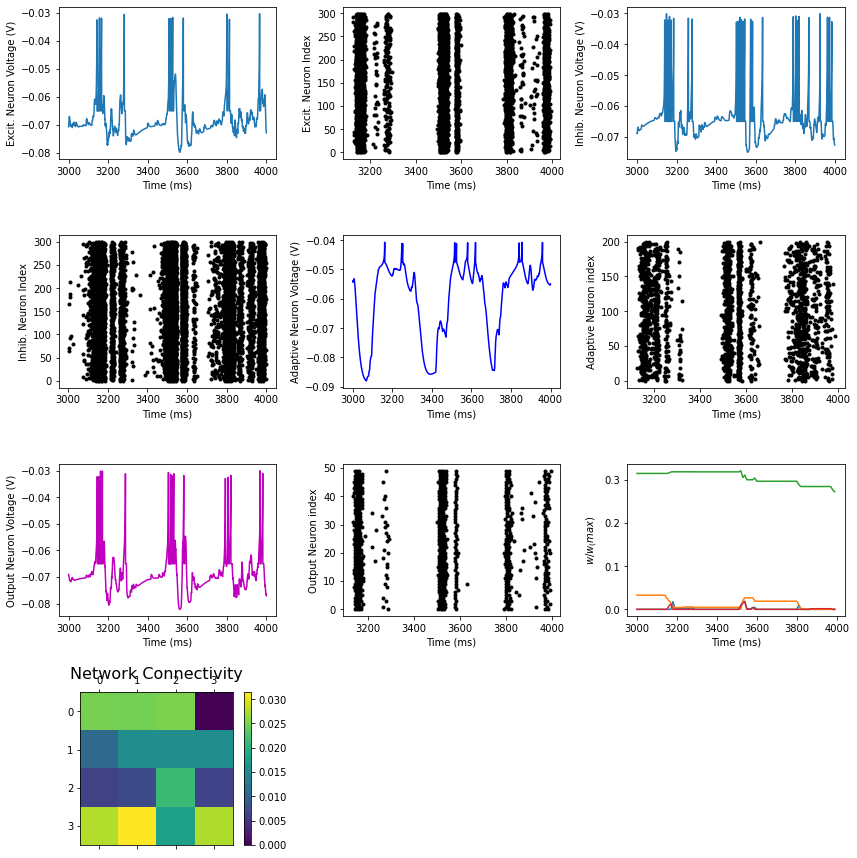

Running Training Epoch 5


Computation Time : 59.13360891699995 seconds


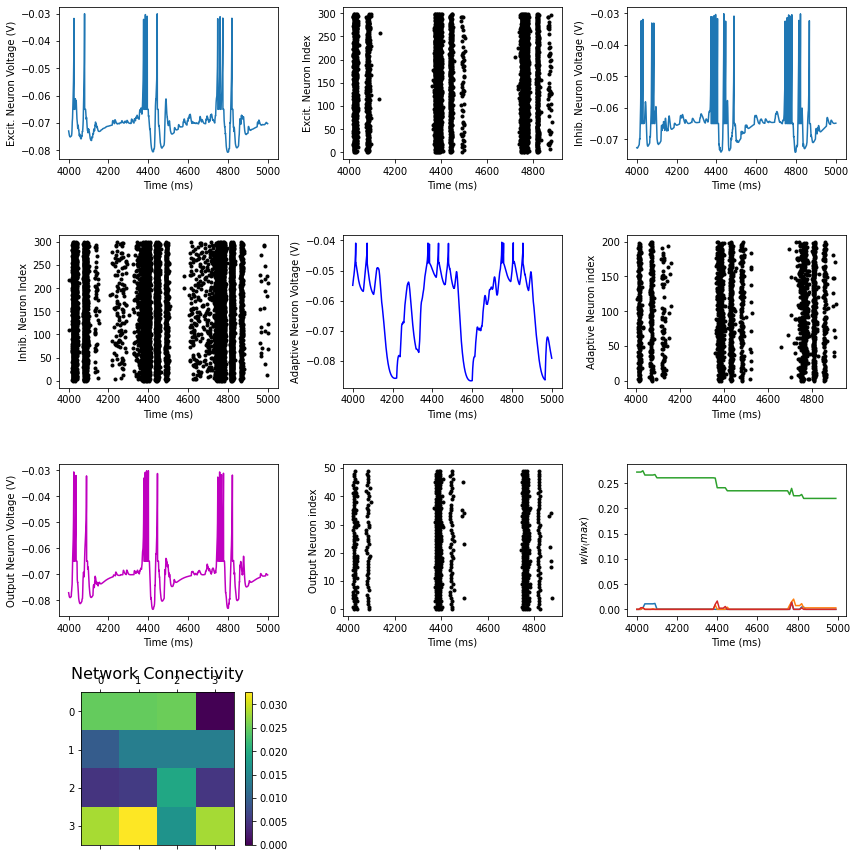

Running Training Epoch 6


Computation Time : 61.83144122199974 seconds


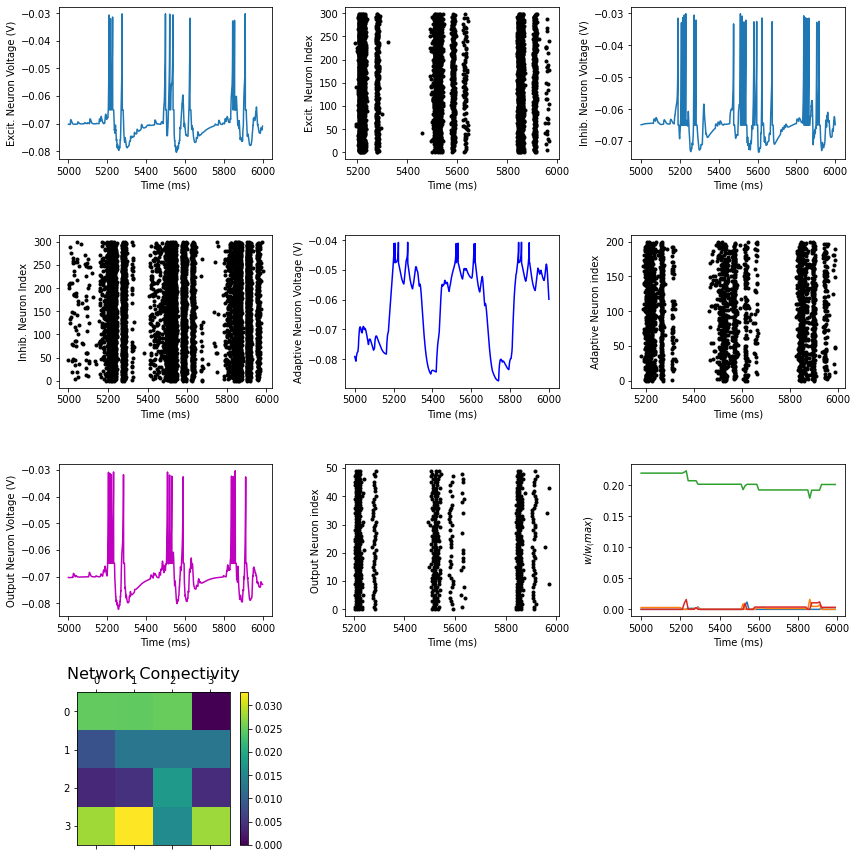

Running Training Epoch 7


Computation Time : 63.97203245200035 seconds


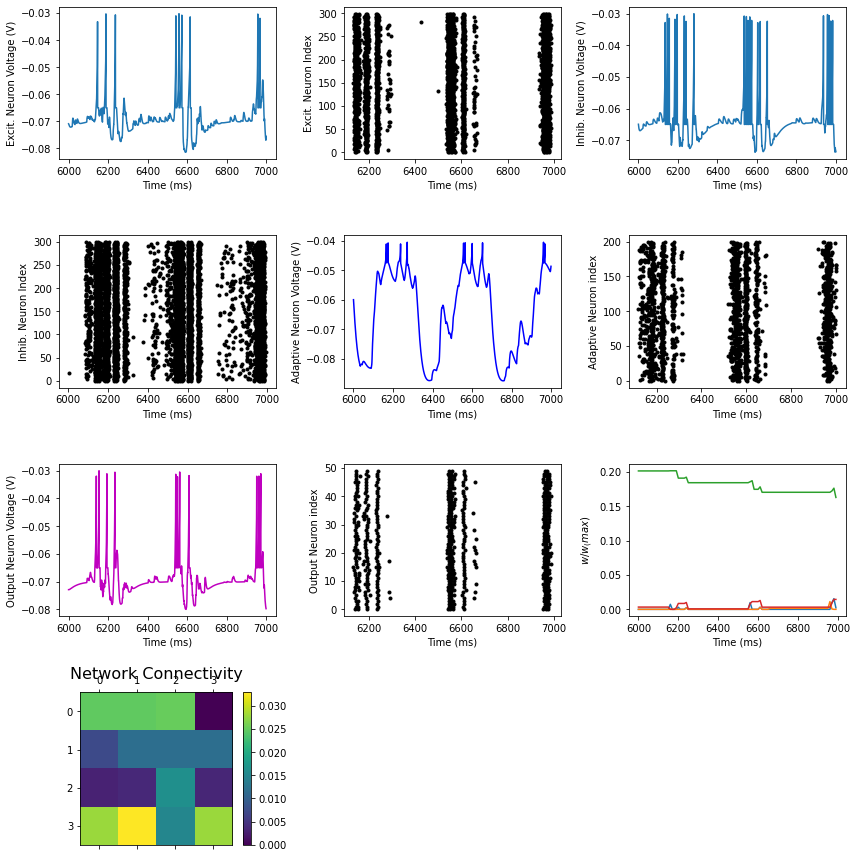

Running Training Epoch 8


Computation Time : 64.35516812299966 seconds


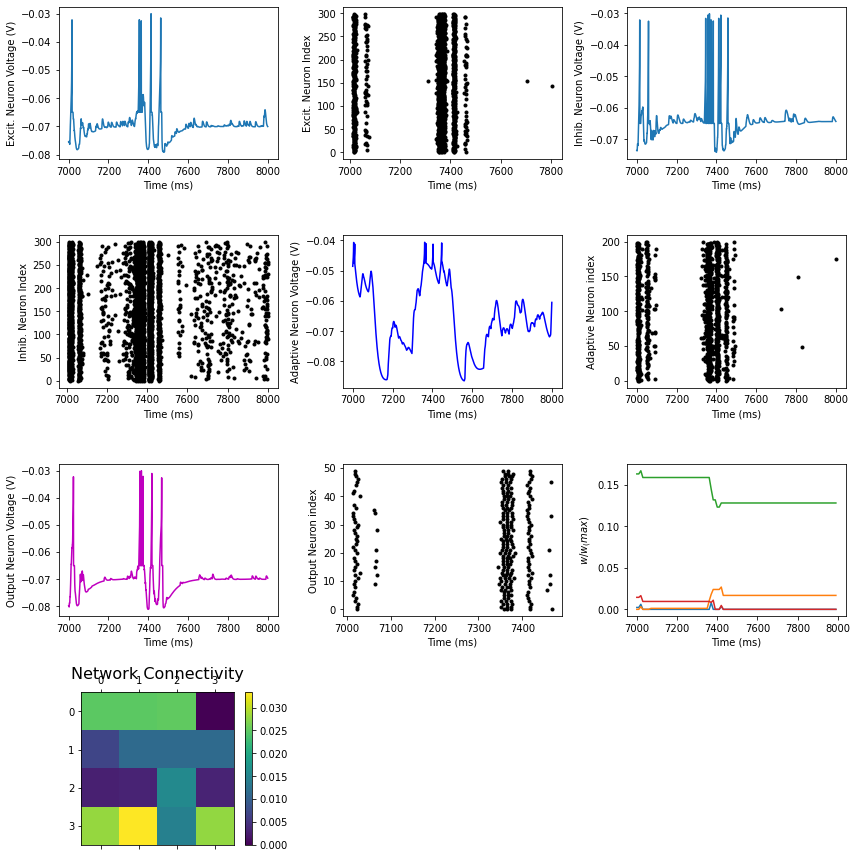

Running Training Epoch 9


Computation Time : 64.1277933780002 seconds


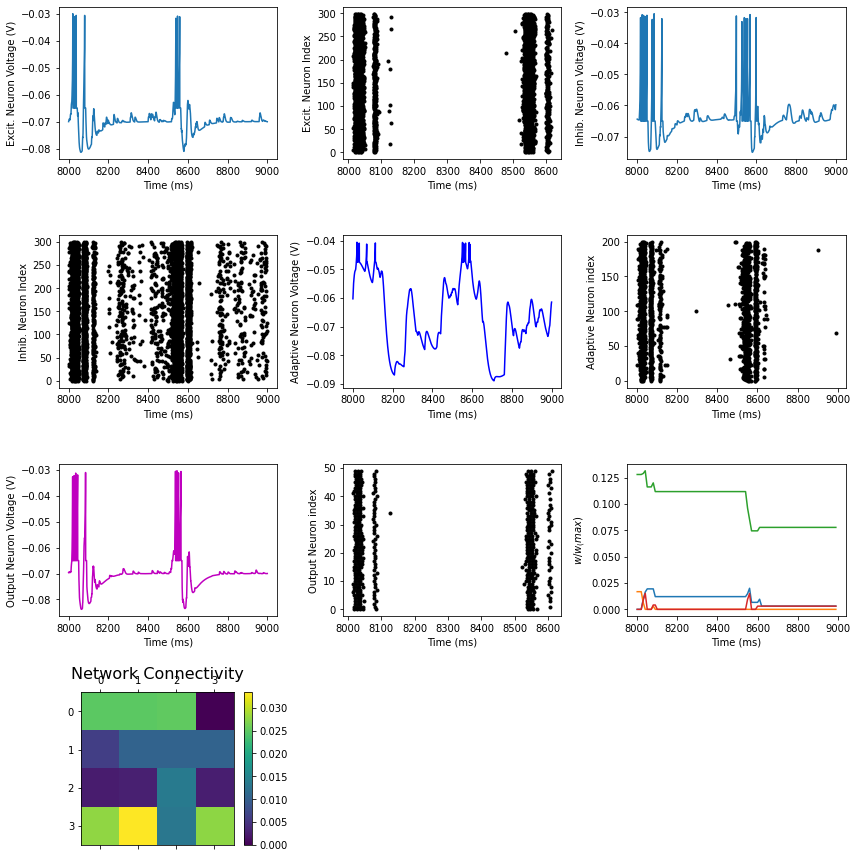

Running Training Epoch 10


Computation Time : 69.76627394999969 seconds


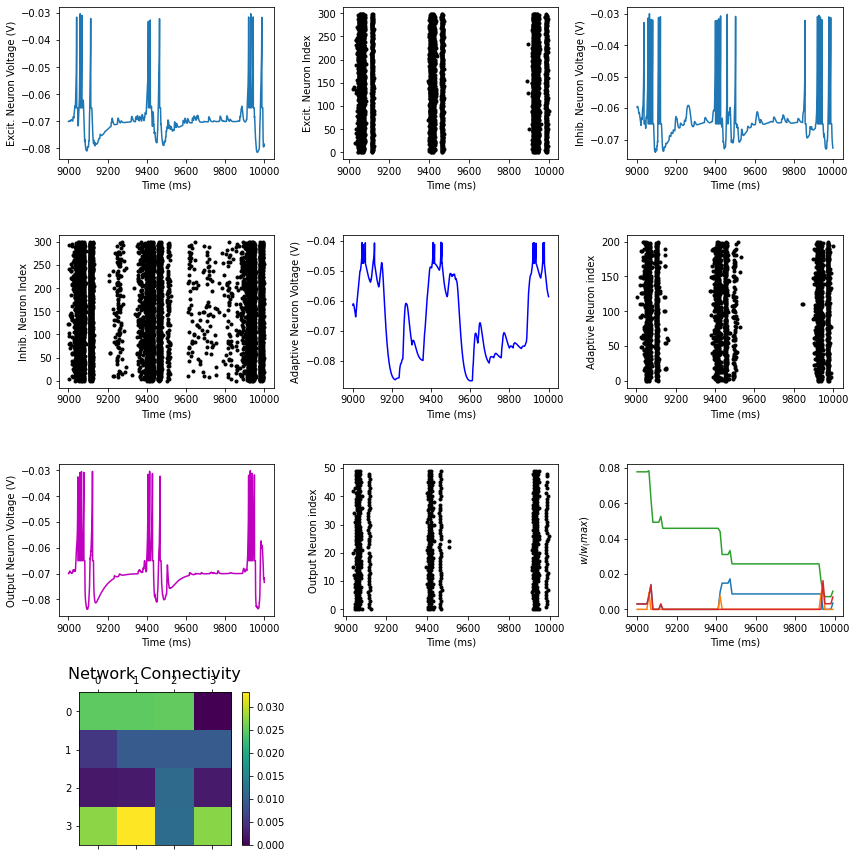

Running Training Epoch 11


Computation Time : 69.22854152400032 seconds


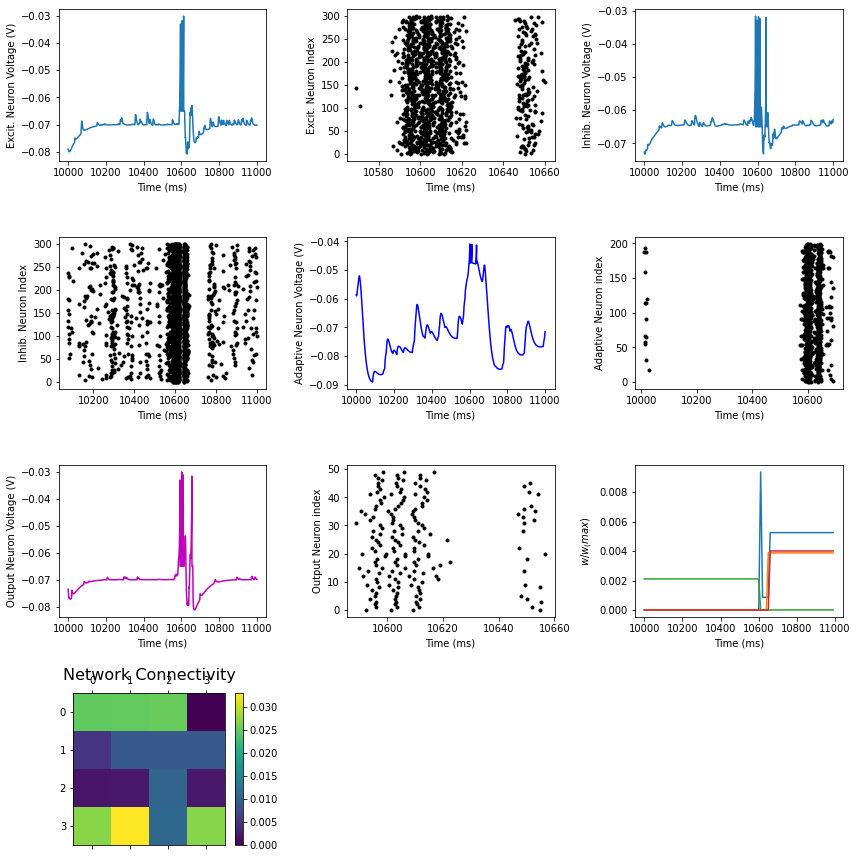

Running Training Epoch 12


Computation Time : 74.16384846200026 seconds


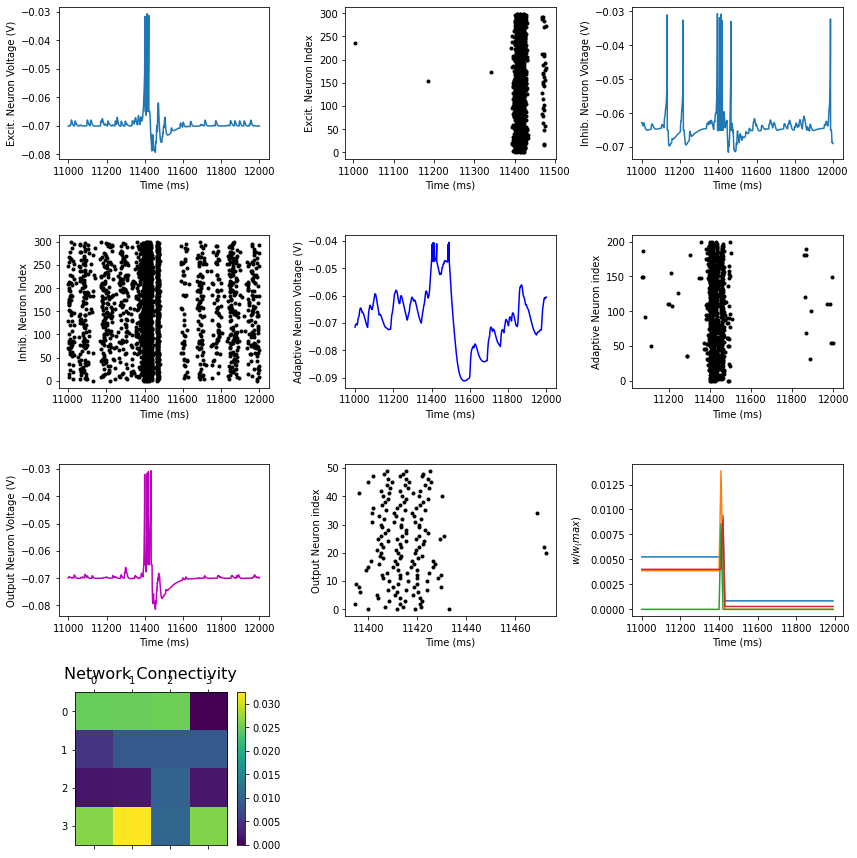

Running Training Epoch 13


Computation Time : 76.74553770800003 seconds


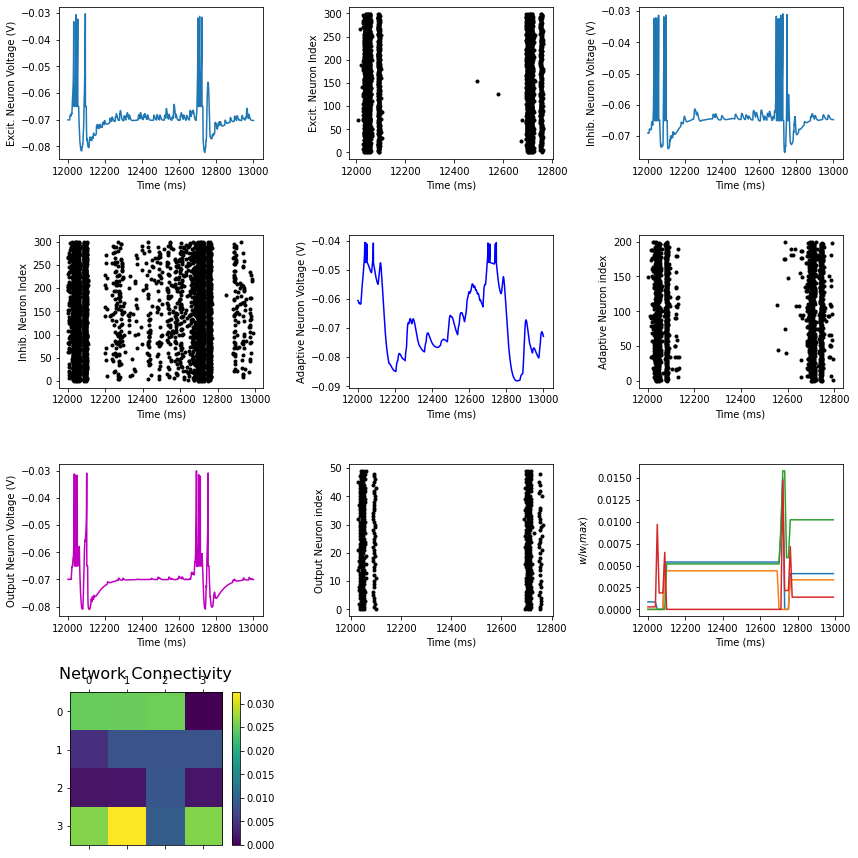

Running Training Epoch 14


Computation Time : 77.10907847899989 seconds


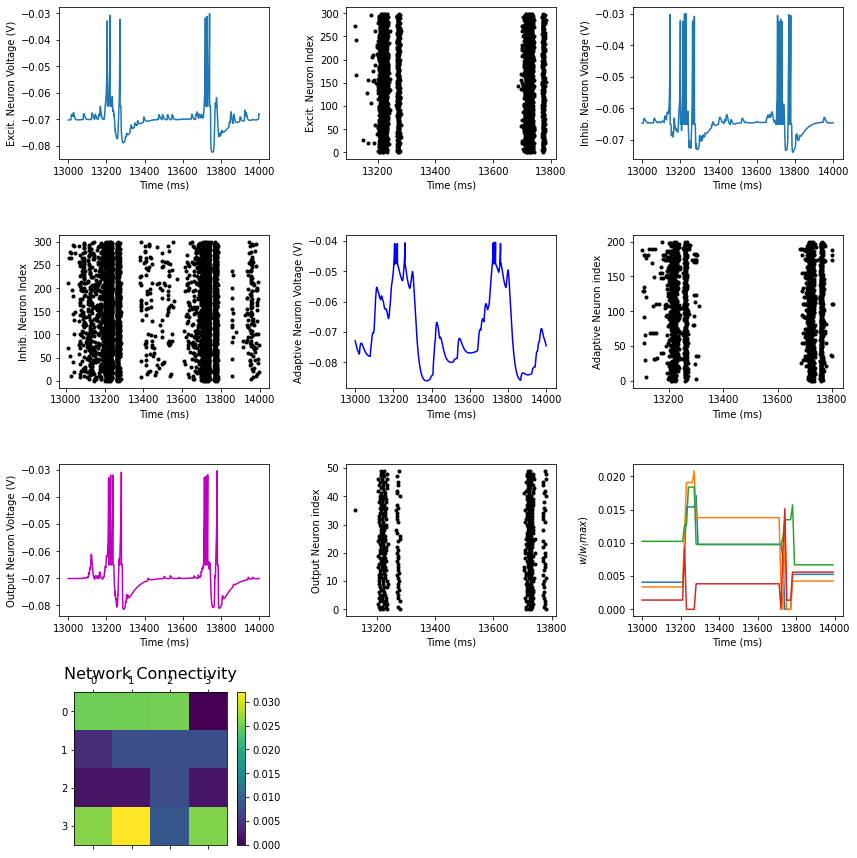

Running Training Epoch 15


Computation Time : 78.56176968499994 seconds


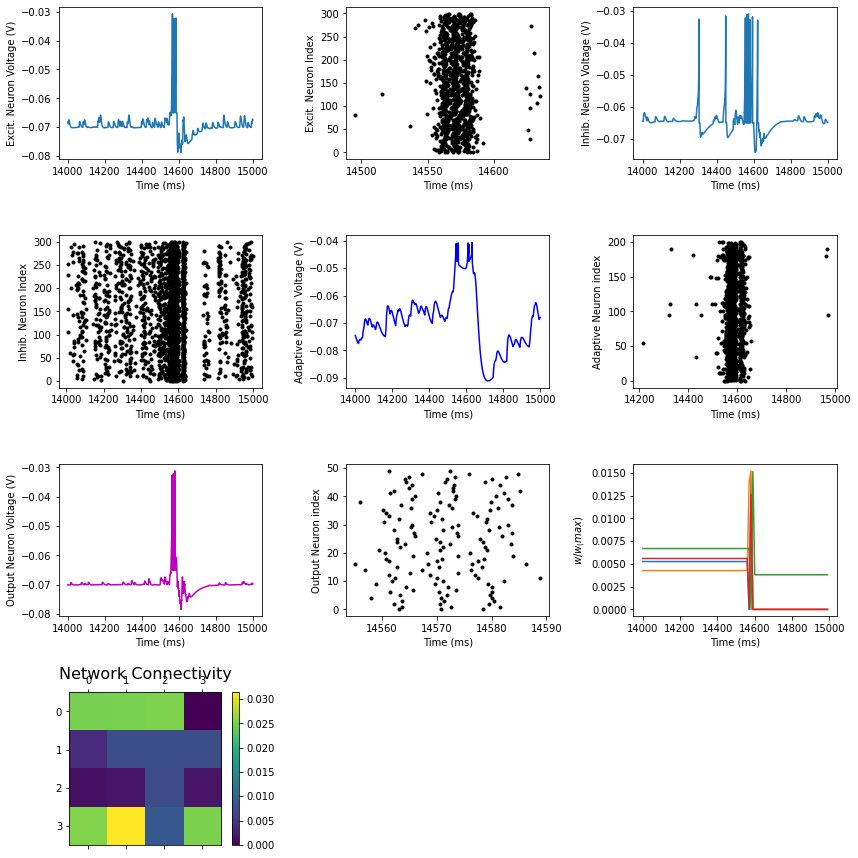

Running Training Epoch 16


Computation Time : 83.53586059700001 seconds


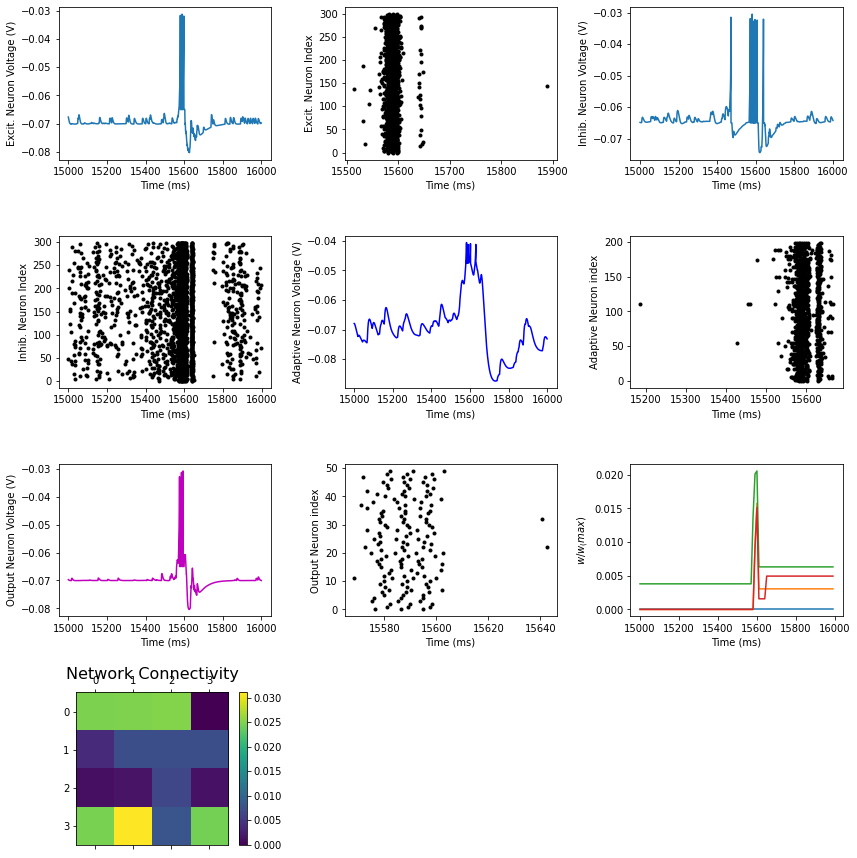

Running Training Epoch 17


Computation Time : 84.01986751000004 seconds


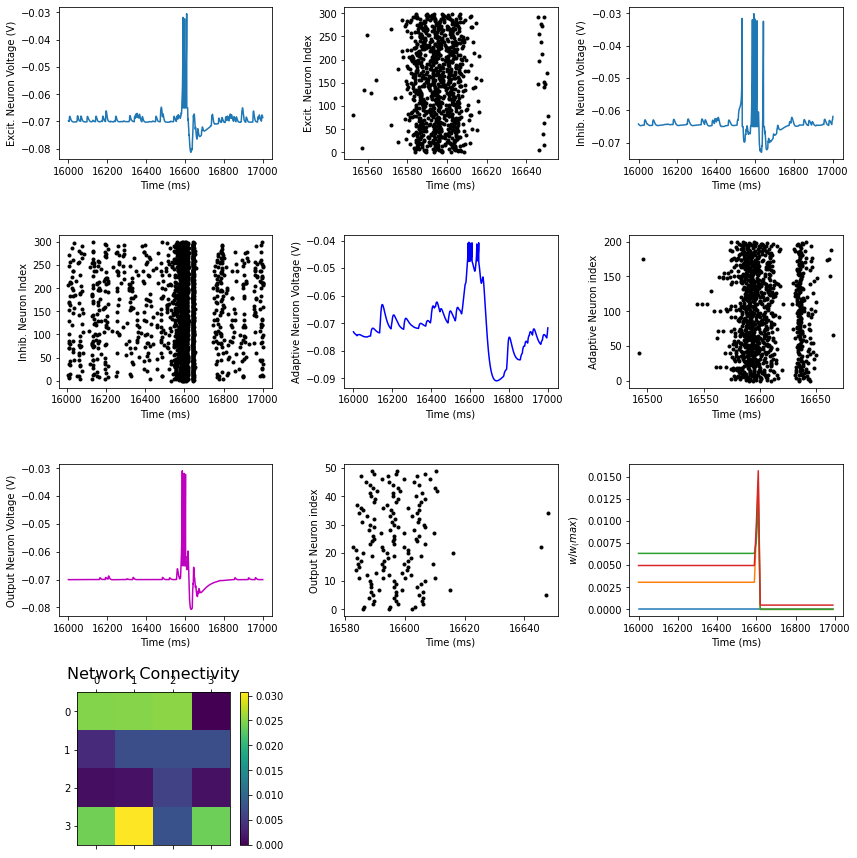

Running Training Epoch 18


Computation Time : 86.44071546500027 seconds


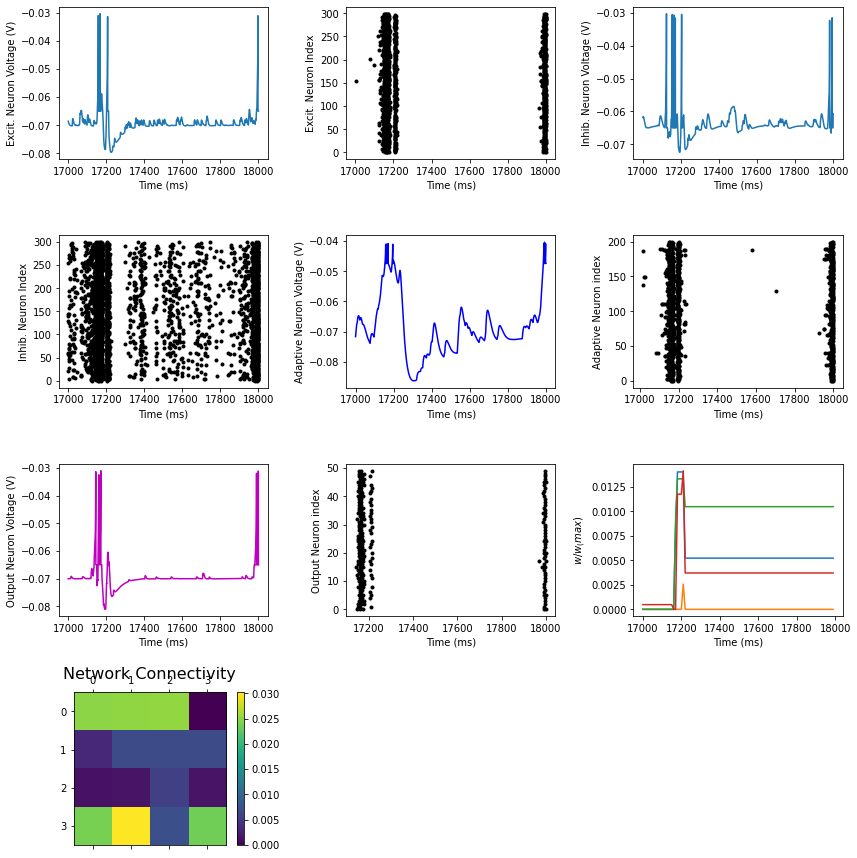

Running Training Epoch 19


Computation Time : 91.42489384700002 seconds


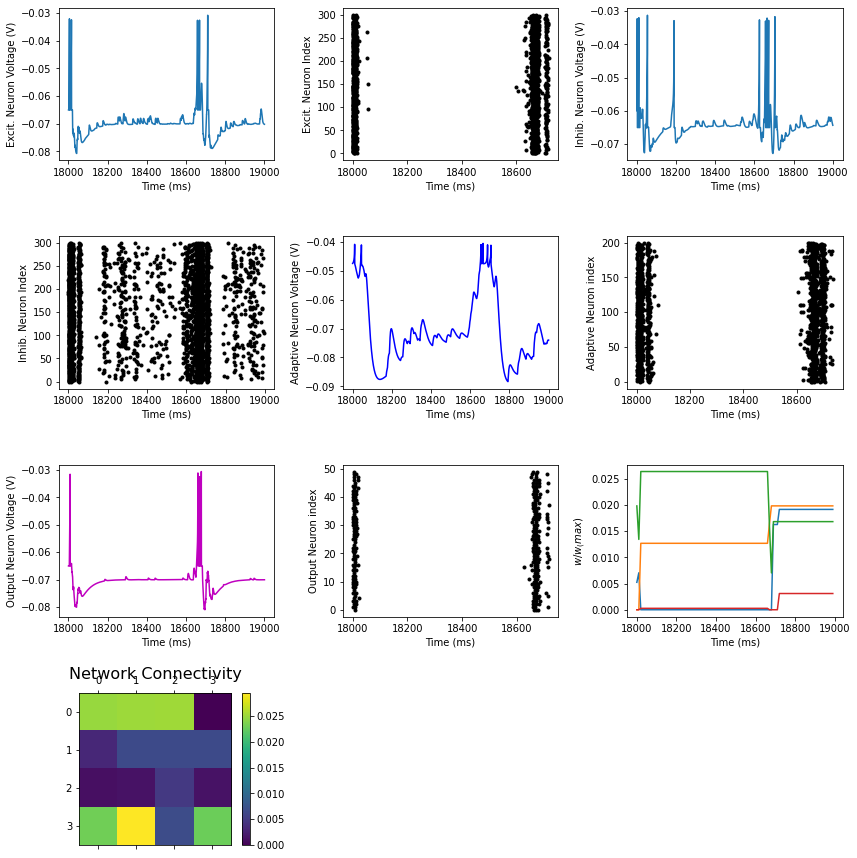

Running Training Epoch 20


Computation Time : 91.85979336199989 seconds


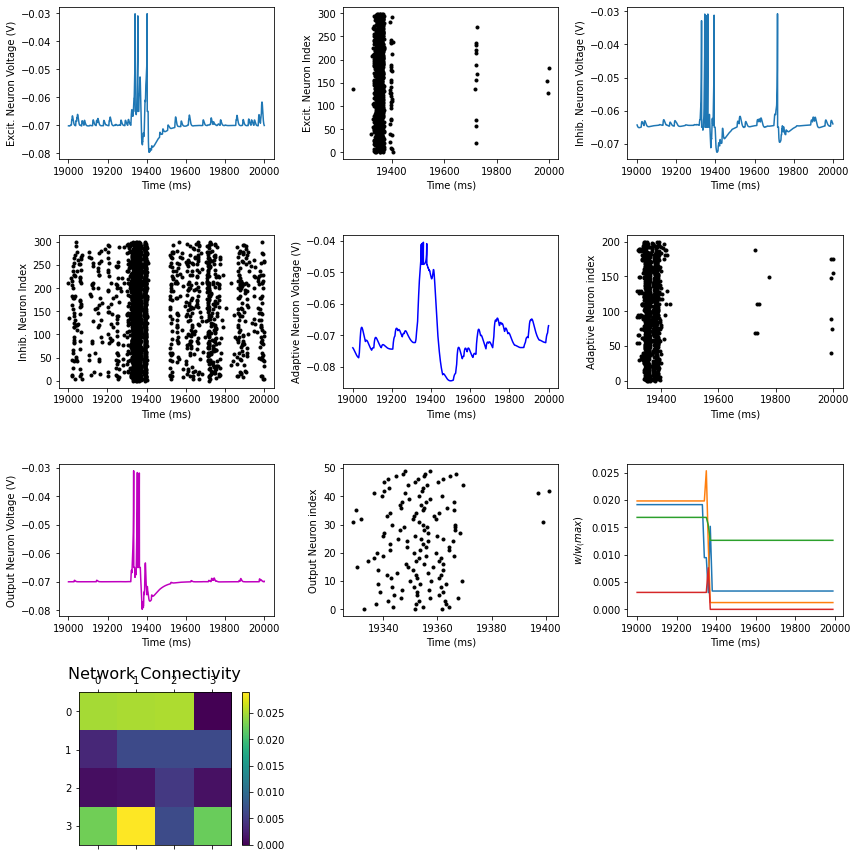

Running Training Epoch 21


Computation Time : 93.56868899200026 seconds


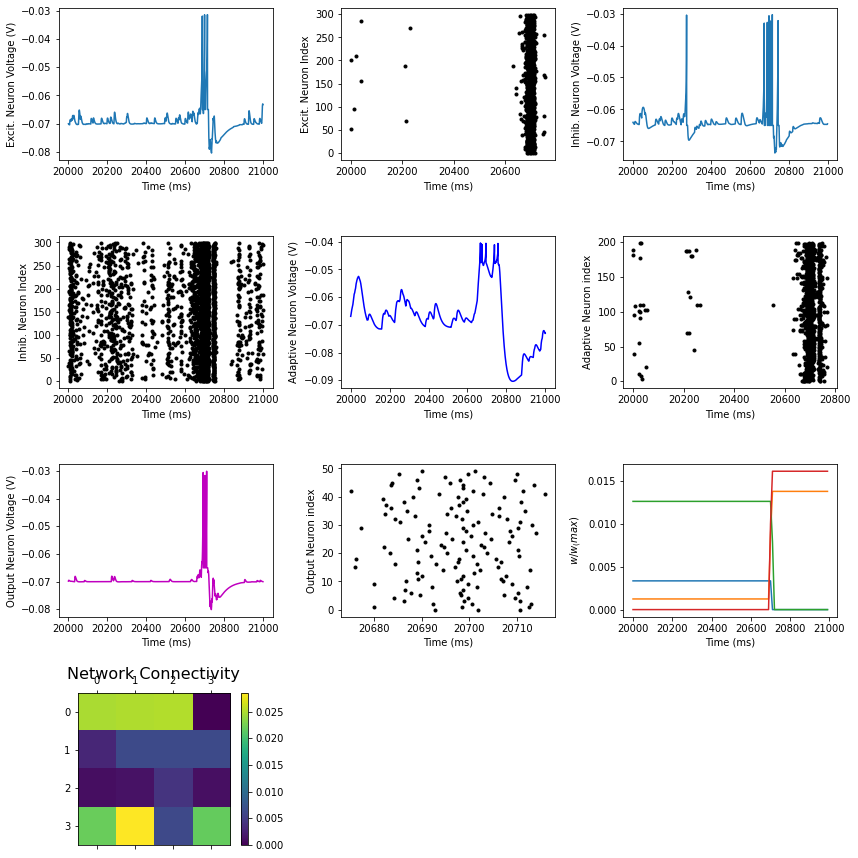

Running Training Epoch 22


Computation Time : 98.1204099190004 seconds


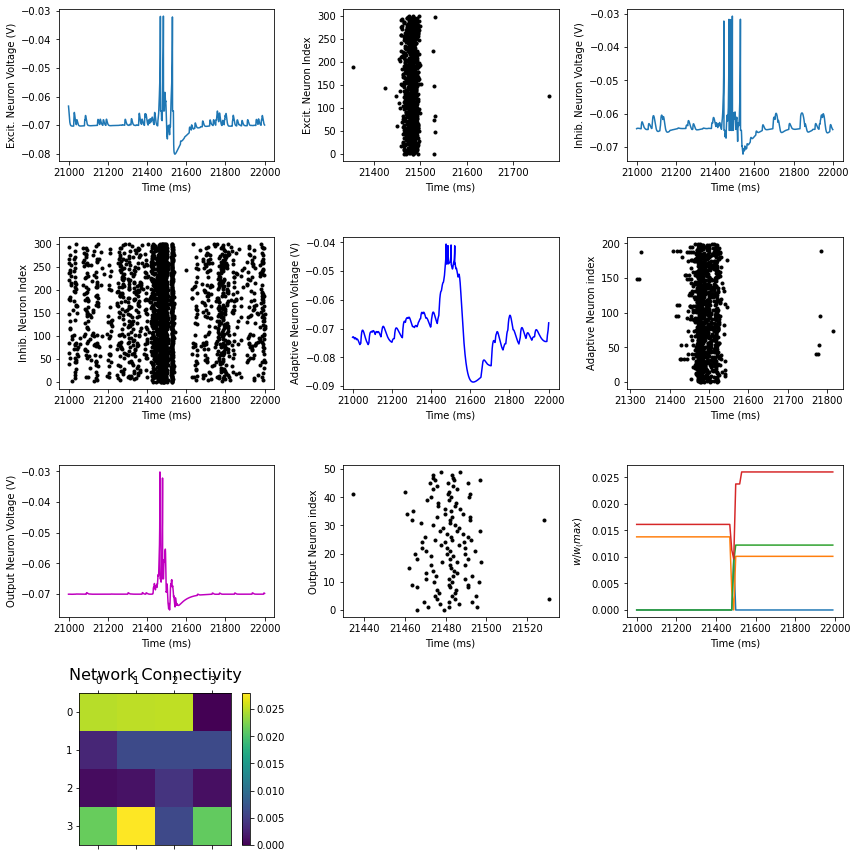

Running Training Epoch 23


Computation Time : 97.60532450300025 seconds


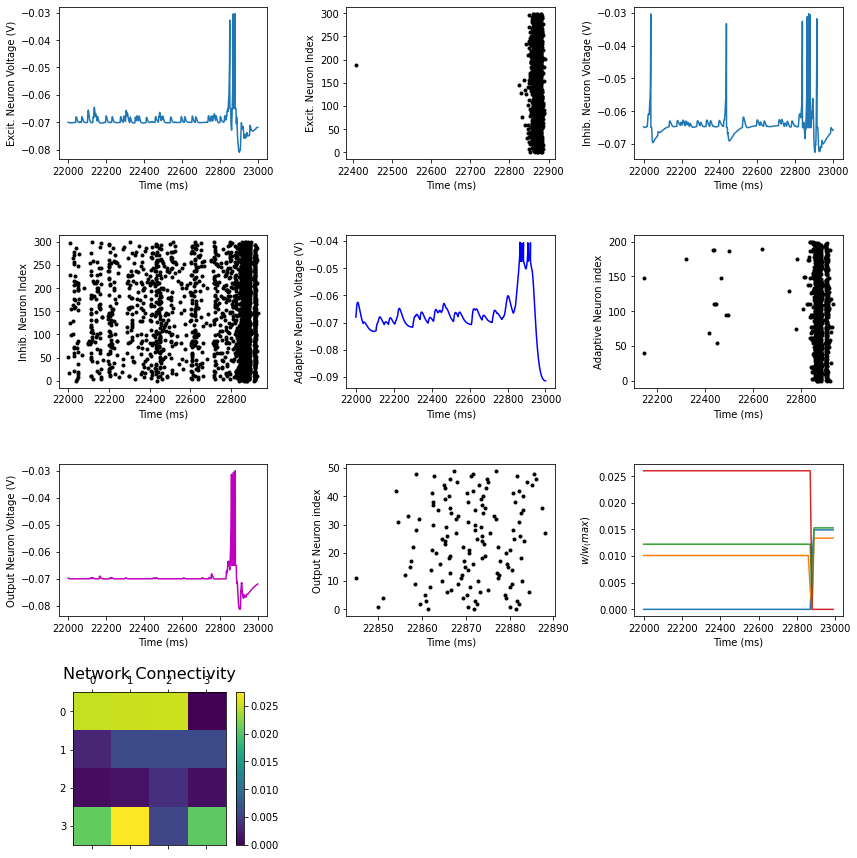

Running Training Epoch 24


Computation Time : 98.87607287900028 seconds


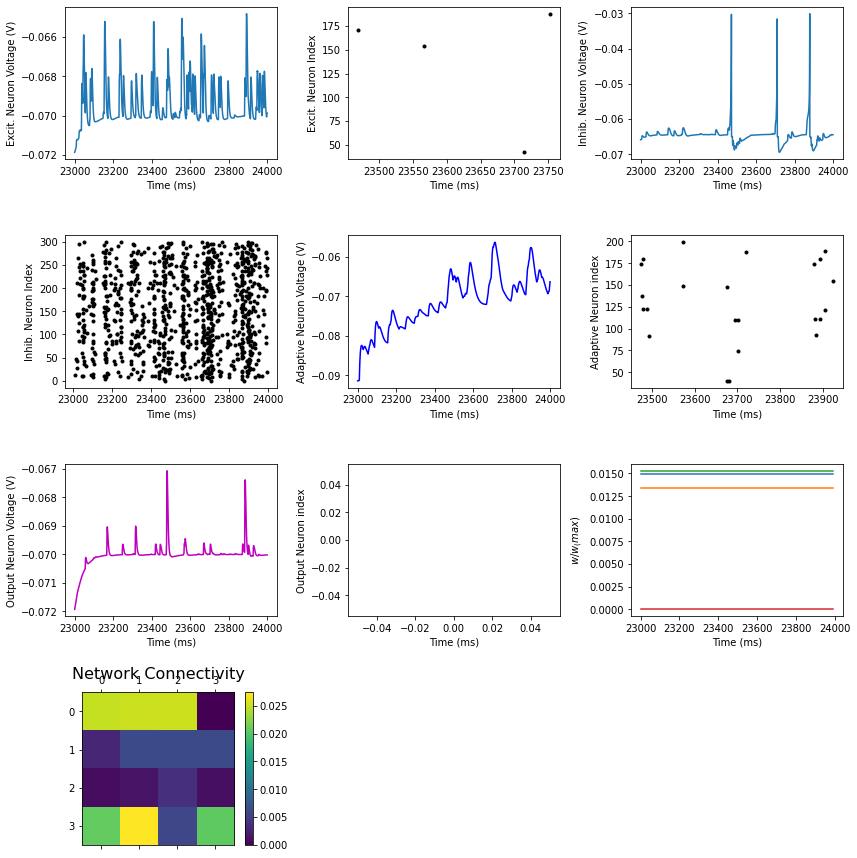

Running Training Epoch 25


Computation Time : 102.7478218350002 seconds


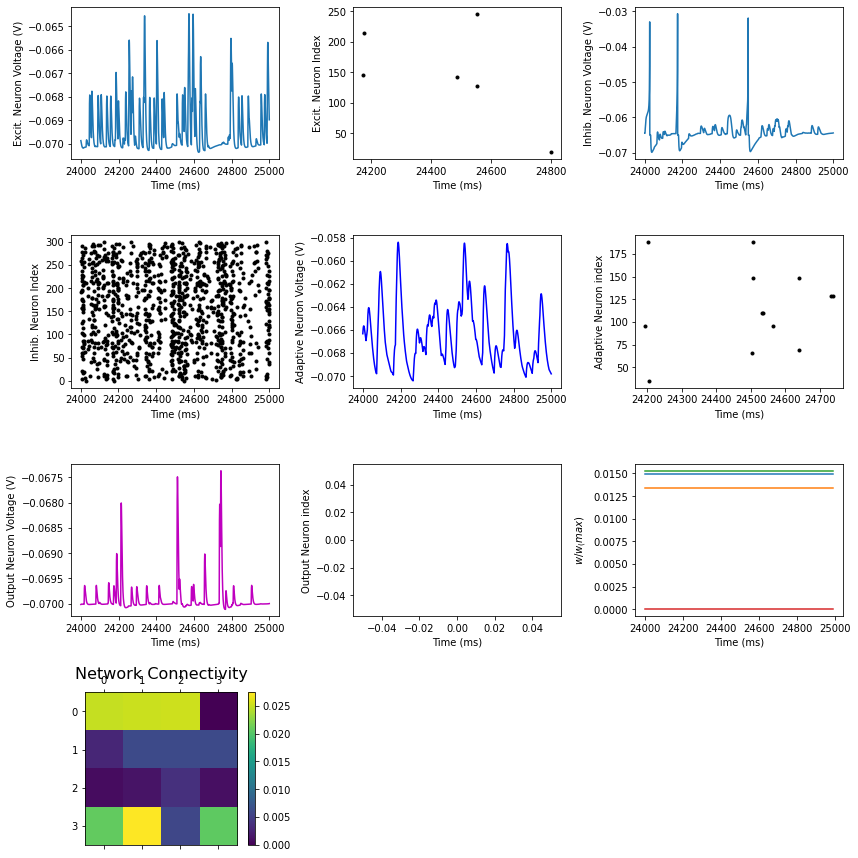

Running Training Epoch 26


Computation Time : 105.12362849100009 seconds


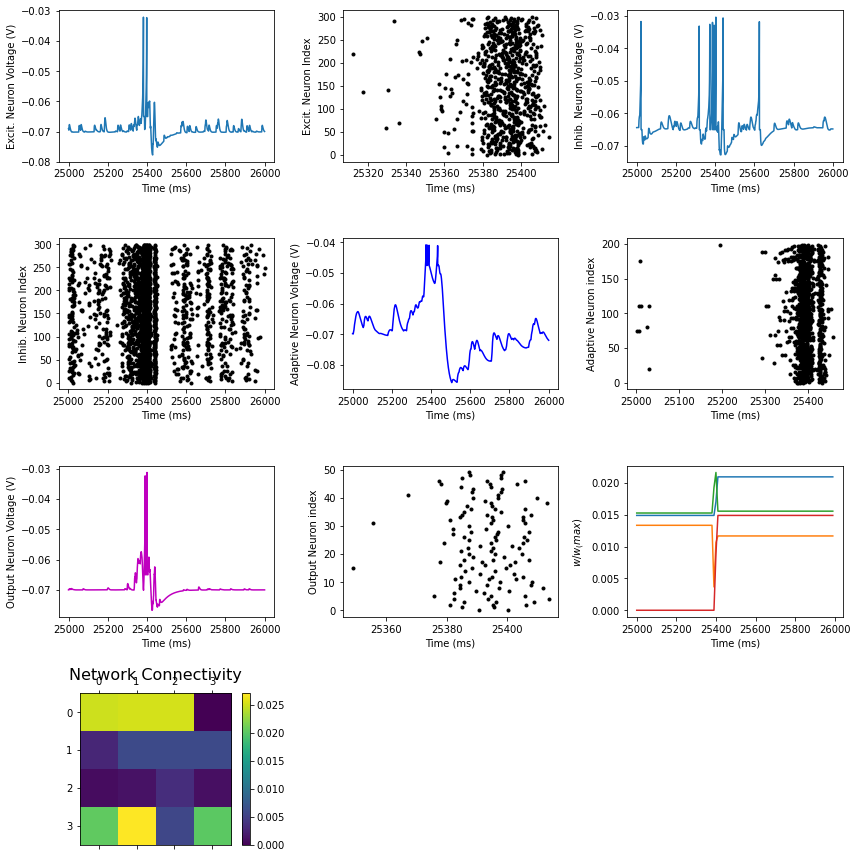

Running Training Epoch 27


Computation Time : 106.51751216599996 seconds


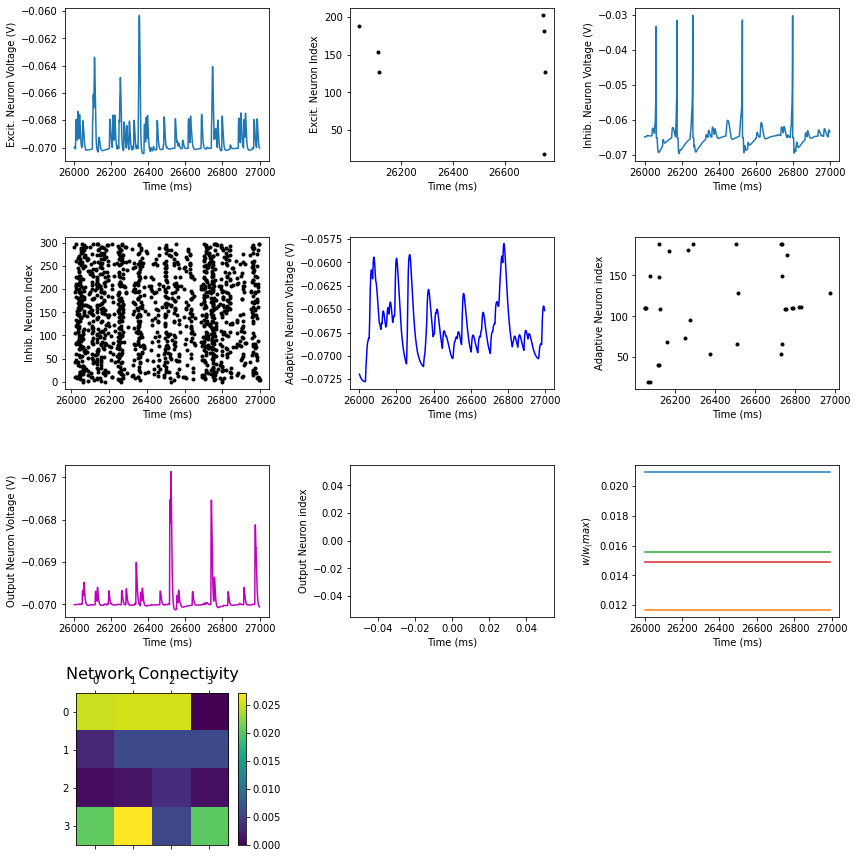

Running Training Epoch 28


Computation Time : 109.94659472500007 seconds


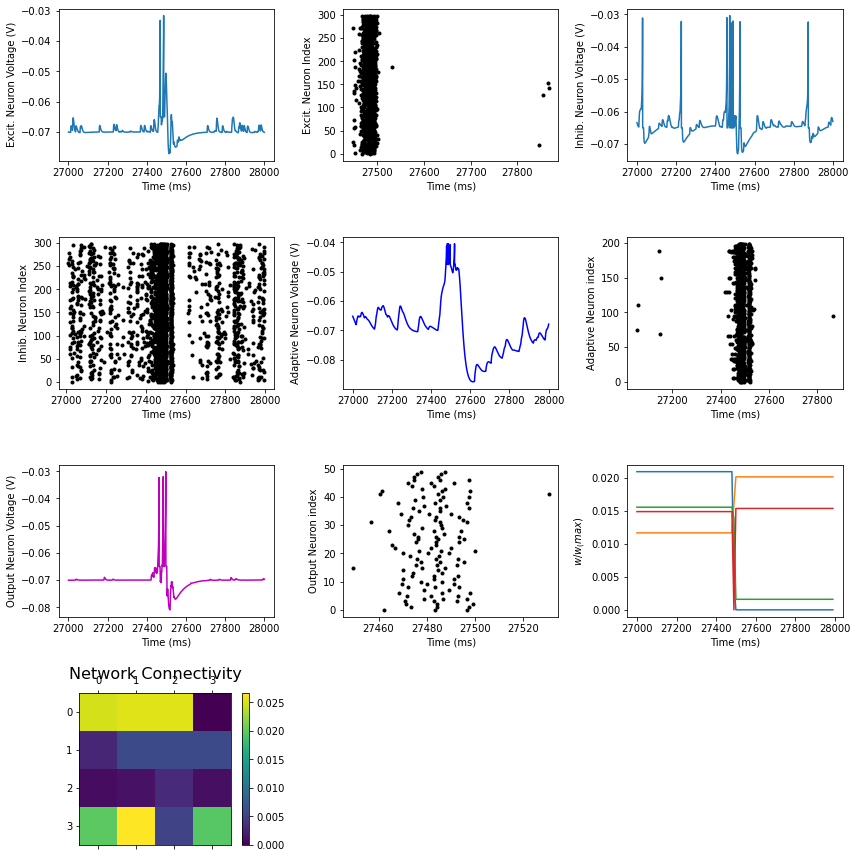

Running Training Epoch 29


Computation Time : 113.00317891600025 seconds


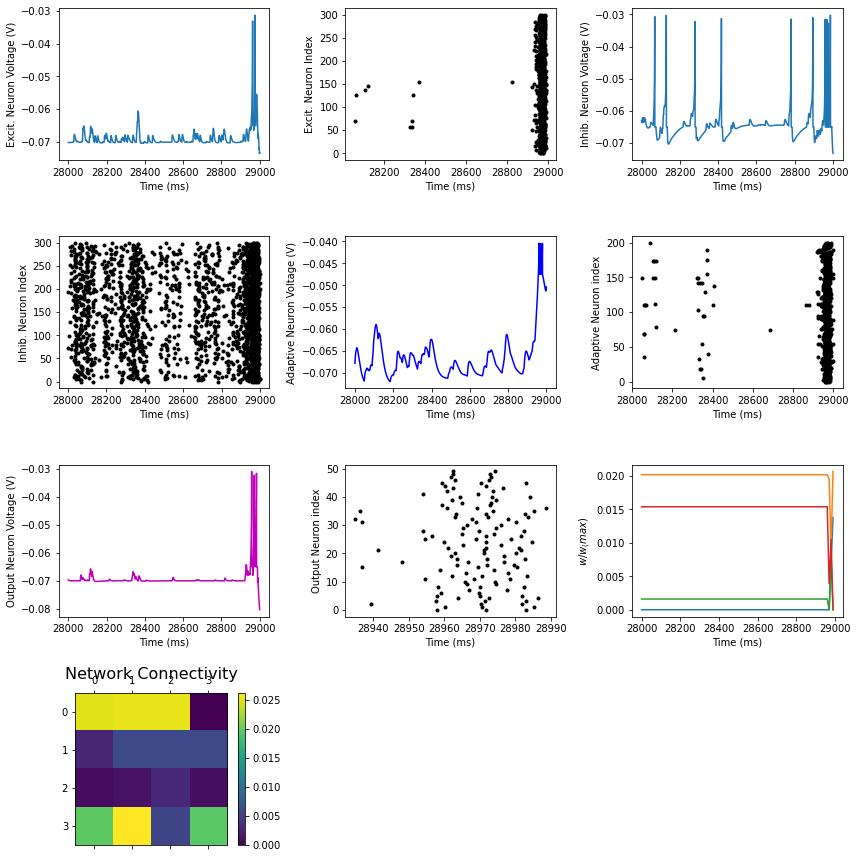

Running Training Epoch 30


Computation Time : 113.10243570299917 seconds


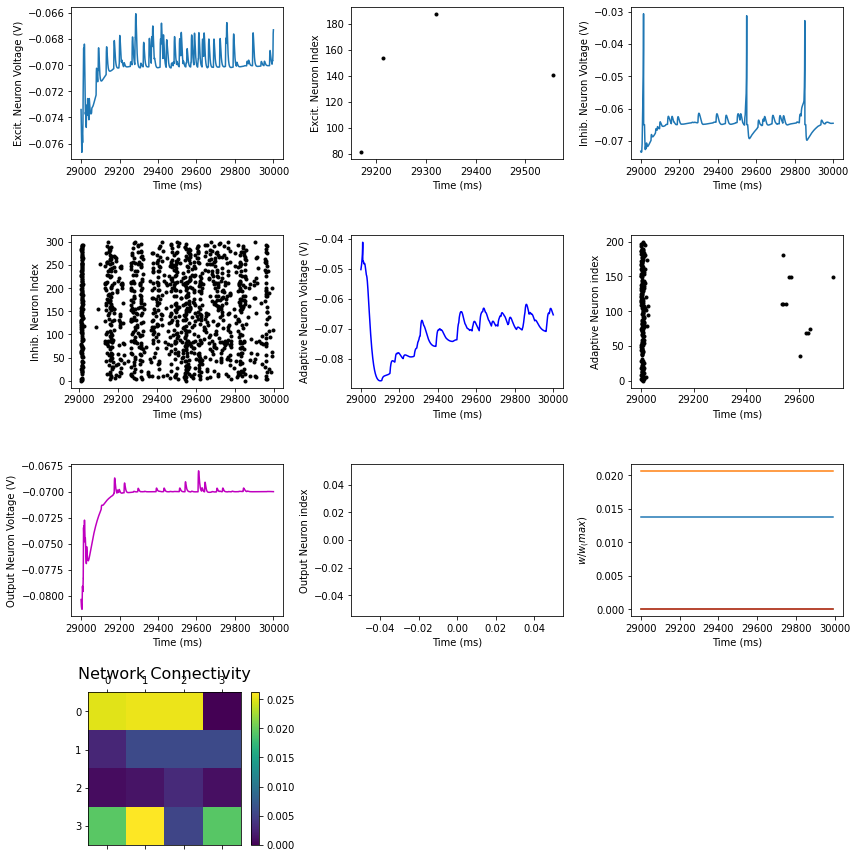

In [ ]:
'''
MAIN CODE
'''
#----------- PARAMETERS ------------#

# -------------SIMULATION PARAMETERS --------------#

training_epochs = 30       # number of STDP training episodes

sim_time        = 1000*ms  # simulation time for each episode     
record_interval = 10*ms    # recording interval for monitoring synaptic weights


# EXCITATORY , INHIBITORY NEURON PARAMETERS 
#-------------------------------------------#
taum     = 25 * ms         # membrane recovery timescale
EL       = -70 *mV         # resting membrane potential
VT       = -50 *mV         # 
R        = 25 *Mohm        # membrane resistance
v_unit   = 1*mV            # for bringing equation to proper dimensions
a        =  0.02/ms        # 
b2       = 0.2/Mohm        #
b_inhib  = 0.25/ms         #
b_excit  = 0.2/ms          #
Vcut     =  -30 *mV        # threshold/cutoff potential
c        = -65 *mV         # membrane resest potential
d_inhib  =  2  * mV/ms     # 
d_excit  = 8 * mV/ms       #
d2       = 8 * nA          #

#------------------------------------#
# ADAPTIVE NEURON PARAMETERS 
#------------------------------------

C         =   200 * pF                  # adaptive neuron capacitance
gL        =   12 * nS                   # adaptive neuron conductance
EL        =  -70 * mV                   # resting membrane potential
VT_adap   =  -50.4 * mV                 # 
DeltaT    =    2 * mV                   #
Vcut_adap =   VT_adap + 5 * DeltaT      # in the paper this was set to 0 mV. but actually neuron spikes once -40 mV is crossed

# Pick an electrophysiological behaviour
tauw, a_adap, b_adap, Vr = 300 * ms, 2 * nS, 0.06 * nA, -47.5 * mV # Adaptive spiking and chattering behaviour
# In particular, Vr determines the adaptive feature: regular spiking (~ - 58 mV)/ chattering (~ -48 mV )

#----------NEURON DYNAMICS : EQUATION --------------------------#

eqs_adap = """
dv/dt=(gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT)+ I_ext + (I_e + I_i) -wa)/C : volt 
dwa/dt=(a_adap*(v-EL)-wa)/tauw : amp
I_ext : amp
I_e = clip(ge * (-v/mV ) * 100* pA, 0 , 600*pA  )  : amp
dge/dt = -ge/(8.0*ms)       : 1
I_i = clip(gi * (-85. -v/mV ) *100 * pA  , -200* pA , 0*pA ) : amp
dgi/dt = -gi/(2.0*ms)       : 1
"""

#I_i = gi * (-100.*mV-v) /mV : amp
#dgi/dt = -gi/(7*ms)       : amp

eqs_inhib = """
dv/dt = (0.04/ms/mV)*v**2+(5/ms)*v+140*mV/ms - u + I_ext + I_e + I_i  : volt (unless refractory)
du/dt = a*(b_inhib*v-u) : volt/second
I_ext : volt/second
I_e = ge * - v /ms           :  volt/second
I_i = gi * (-85.*mV-v) /ms  : volt/second
dge/dt = -ge/(2.0*ms)       : 1
dgi/dt = -gi/(1.4*ms)       : 1
"""
    
eqs_excit = """
dv/dt = (0.04/ms/mV)*v**2+(5/ms)*v+140*mV/ms - u + I_ext + (I_e +I_i) : volt (unless refractory)
du/dt = a*(b_excit*v-u) : volt/second
I_ext : volt/second
I_e = ge * - v /ms           :  volt/second 
I_i = gi * (-85.*mV-v) /ms  : volt/second  
dge/dt = -ge/(4.0*ms)       : 1
dgi/dt = -gi/(2.2*ms)       : 1

"""

# ------------- SYNAPSES  ----------------------# 
# synapse parameters go here:


wmax        = 0.05           # maximum synaptic weight
gmax        = 0.05          # maximum conductance parameter
delay_max   = 8             # maximum axon conduction delay
delay_min   = 2             # minimum axon conduction delay
taupre      = 20 *ms        #
taupost     = 20 *ms 
tau_post2   = 40 *ms        # I think the 2 post signals have to do with an
# 'excitatory' and inhibitory leakage current associated with each neuron

nu_pre      = 0.0001        # STDP learning rate
nu_post     = 0.01          # STDP learning rate
dApre       = .01           # pre synapse STDP increment 
dApost      = -dApre * taupre / taupost * 1.05
dApost      *= gmax         # scale STDP increment with conductance parameter
dApre       *= gmax         # scale STDP increment with conductance parameter
train_mode  = True          # set STDP training mode

# ---------------- SYNAPSE EQUATIONS  ------------------# 
# -----  syn eqn excit+inhib neuron -----#
syn_model = 'w : 1 '
pre   = '''ge += w  
           gi += w  ''' 
 
post  = ''

stdp_model = '''
            dApre/dt = -Apre / taupre : 1 (event-driven)
            dApost/dt = -Apost / taupost : 1 (event-driven)
             '''
stdp_pre  = 'Apre += dApre; w = clip(w + Apost, 0, gmax)'
stdp_post = 'Apost += dApost ; w = clip(w + Apre, 0, gmax)'

if train_mode:
    syn_model += stdp_model
    pre += ';'+ stdp_pre
    post += stdp_post


# -----  syn eqn adaptive neuron -----#

syn_model_adap = 'w : 1'
pre_adap   = '''ge += w
                gi += w  ''' 
 
post_adap  = ''

stdp_model_adap = '''
                dApre/dt = -Apre / taupre : 1 (event-driven)
                dApost/dt = -Apost / taupost : 1 (event-driven)
                '''

stdp_pre_adap  = 'Apre += dApre; w = clip(w + Apost, 0, wmax)'
stdp_post_adap = 'Apost += dApost ; w = clip(w + Apre, 0, wmax)'



train_mode = True 

if train_mode:
    syn_model_adap += stdp_model_adap
    pre_adap += ';'+ stdp_pre_adap
    post_adap += stdp_post_adap


# Synapse Connectivity function: returns weight matrix, connection matrix to be used by Brian

def Synapse_connectivity(N1, N2, p, self_recurrency):

    bin_mat = np.random.binomial(1, p = 0.15 , size = N1*N2).reshape(N1, N2)

    if self_recurrency:
        np.fill_diagonal(bin_mat, 0)
    else:
        pass

    connection_mat = np.full(( N1 ,N2 ) , np.nan)
    connection_mat[bin_mat == 1] = 1 

    weight_mat =  (wmax*np.random.random(N1*N2).reshape(N1 , N2))*connection_mat

    #weight_mat = weight_mat/ np.nansum(weight_mat , axis = 0 )     # normalise weights feeding into each neuron
    weight_mat = weight_mat[~np.isnan(weight_mat)]

    return bin_mat, weight_mat




# Synpase Delay for Synapses class Brian

def Synapse_delay(S):

    return  (((delay_max-delay_min)*np.random.random(len(S)) + delay_min )*ms).flatten() 


def normalise_weight(S):
    
    S = S / np.nansum(S, axis = 0 )
    return S


    

#-----------------POISSON INPUT -----------------------------------#

firing_rate     = 40 #Hz    #Here we model the input to be Poisson, normally
sigma           =  1.5      #centered around the target with a certain standard
x_dim           = 15        #deviation. The input encodes information relayed by 
y_dim           = 15        #place cells. 

target_x        = 5
target_y        = 5

num_inputs      = x_dim*y_dim  
input_rates     = []        # initialise input_rates list to be taken by PoissonGroup

for i in range(x_dim):
    for j in range(y_dim):
        diff = (target_x - i)**2 + (target_y - j)**2
        rate =  firing_rate*math.exp(-diff/sigma**2) 
        input_rates.append(rate)

P = PoissonGroup(num_inputs, rates = input_rates*hertz)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(sim_time*training_epochs)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)

# #-----------------MODEL: INITIALISE NEURON GROUPS -----------------------------------#

N = [300, 300, 200, 50]


G1 = NeuronGroup(N[0], model=eqs_excit, threshold= 'v >= Vcut', reset="v=c;u+=d_excit", refractory=5*ms, method='euler')

G2 = NeuronGroup(N[1], model=eqs_inhib, threshold= 'v >= Vcut', reset="v=c;u+=d_inhib", refractory=5*ms, method='euler')

G3 = NeuronGroup(N[2], model=eqs_adap, threshold= 'v > Vcut_adap', reset="v=Vr;wa+=b_adap", method = 'euler')

G4 = NeuronGroup(N[3], model=eqs_excit, threshold= 'v >= Vcut', reset="v=c;u+=d_excit", refractory=5*ms, method='euler')

G1.v = EL
G1.u = b_excit * EL
#excit_neuron.I = list(10*np.array(input_current[0]))*mV/ms

G2.v = EL
G2.u = b_inhib * EL
#inhib_neuron.I =  list(10*np.array(input_current[1]))*mV/ms


G3.v = EL
#G3.wa = a_adap * (G3.v - EL)
#G3.wa = 0.5 * pA
#adap_neuron.I = (input_current[2]) * nA

G4.v = EL
G4.u = b_excit * EL

# ----------- INITIALISE SYNAPSES --------------------------#

SPG1  = Synapses(SGG,G1, syn_model , on_pre= pre,on_post =  post )

bin_mat, weight_mat = Synapse_connectivity(num_inputs, N[0], 0.25,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SPG1.connect( i = sources, j = targets)
SPG1.w = weight_mat
#SPG1.w = '(1.0/N_incoming)'

SPG1.delay = Synapse_delay(SPG1)

SPG2  = Synapses(SGG,G2, syn_model ,on_pre= pre,on_post =  post)
bin_mat, weight_mat = Synapse_connectivity(num_inputs, N[1], 0.25,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SPG2.connect( i = sources, j = targets)
SPG2.w = weight_mat
#SPG2.w = '(1.0/N_incoming)'


SPG2.delay = Synapse_delay(SPG2)


SPG3  = Synapses(SGG,G3, syn_model_adap ,on_pre= pre_adap,on_post =  post_adap)

bin_mat, weight_mat = Synapse_connectivity(num_inputs, N[2], 0.35,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SPG3.connect( i = sources, j = targets)
SPG3.w = weight_mat
#SPG3.w = '(1.0/N_incoming)*nA'

SPG3.delay = Synapse_delay(SPG3)

SG1G1 = Synapses(G1,G1,syn_model ,on_pre= pre, on_post =  post) 
SG1G2 = Synapses(G1,G2,syn_model ,on_pre= pre,on_post =  post)
SG1G3 = Synapses(G1,G3,syn_model_adap ,on_pre= pre_adap,on_post =  post_adap)
SG1G4 = Synapses(G1,G4,syn_model ,on_pre= pre,on_post =  post)


SG2G1 = Synapses(G2,G1,syn_model ,on_pre= pre,on_post =  post)
SG2G2 = Synapses(G2,G2,syn_model ,on_pre= pre,on_post =  post)
SG2G3 = Synapses(G2,G3,syn_model_adap ,on_pre= pre_adap,on_post =  post_adap)
SG2G4 = Synapses(G2,G4,syn_model ,on_pre= pre,on_post =  post)

SG3G1 = Synapses(G3,G1,syn_model ,on_pre= pre,on_post =  post)
SG3G2 = Synapses(G3,G2,syn_model ,on_pre= pre,on_post =  post)
SG3G3 = Synapses(G3,G3,syn_model_adap ,on_pre= pre_adap,on_post =  post_adap)
SG3G4 = Synapses(G3,G4,syn_model ,on_pre= pre,on_post =  post)


bin_mat, weight_mat = Synapse_connectivity(N[0], N[0], 0.05, self_recurrency= True)
sources, targets = bin_mat.nonzero()
SG1G1.connect( i = sources, j = targets)
SG1G1.w = weight_mat


bin_mat, weight_mat = Synapse_connectivity(N[0], N[1], 0.08 ,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG1G2.connect( i = sources, j = targets)
SG1G2.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[0], N[2], 0.1,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG1G3.connect( i = sources, j = targets)
SG1G3.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[0], N[3], 0.15,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG1G4.connect( i = sources, j = targets)
SG1G4.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[1], N[0], 0.12,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG2G1.connect( i = sources, j = targets)
SG2G1.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[1], N[1], 0.05, self_recurrency= True)
sources, targets = bin_mat.nonzero()
SG2G2.connect( i = sources, j = targets)
SG2G2.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[1], N[2], 0.1 ,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG2G3.connect( i = sources, j = targets)
SG2G3.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[1], N[3], 0.15 ,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG2G4.connect( i = sources, j = targets)
SG2G4.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[2], N[0], 0.08 ,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG3G1.connect( i = sources, j = targets)
SG3G1.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[2], N[1], 0.08,self_recurrency= False) 
sources, targets = bin_mat.nonzero()
SG3G2.connect( i = sources, j = targets)
SG3G2.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[2], N[2], 0.05, self_recurrency= True)
sources, targets = bin_mat.nonzero()
SG3G3.connect( i = sources, j = targets)
SG3G3.w = weight_mat

bin_mat, weight_mat = Synapse_connectivity(N[2], N[3], 0.1 ,self_recurrency= False)
sources, targets = bin_mat.nonzero()
SG3G4.connect( i = sources, j = targets)
SG3G4.w = weight_mat



SG1G1.delay = Synapse_delay(SG1G1)
SG1G2.delay = Synapse_delay(SG1G2)
SG1G3.delay = Synapse_delay(SG1G3)
SG1G4.delay = Synapse_delay(SG1G4)

SG2G1.delay = Synapse_delay(SG2G1)
SG2G2.delay = Synapse_delay(SG2G2)
SG2G3.delay = Synapse_delay(SG2G3)
SG2G4.delay = Synapse_delay(SG2G4)

SG3G1.delay = Synapse_delay(SG3G1)
SG3G2.delay = Synapse_delay(SG3G2)
SG3G3.delay = Synapse_delay(SG3G3)
SG3G4.delay = Synapse_delay(SG3G4)

# -------------- INITIALISE STATE MONITORS ---------------------#

G1_statemon = StateMonitor(G1, 'v', record=0)
G1_spikemon = SpikeMonitor(G1)

G2_statemon = StateMonitor(G2, 'v', record=0)
G2_spikemon = SpikeMonitor(G2)

G3_statemon = StateMonitor(G3, 'v', record=0)
G3_spikemon = SpikeMonitor(G3)

G4_statemon = StateMonitor(G4, 'v', record=0)
G4_spikemon = SpikeMonitor(G4)


arr = np.random.choice(range(0,50), size = 4, replace = False)                  # Record random synapses with the monitor.
SG1G4_synmon = StateMonitor(SG1G4, 'w', record= arr, dt = record_interval) 
#SG2G4_synmon = StateMonitor(SG1G4, 'w', record=[0,1], dt = record_interval) 
#SG3G4_synmon = StateMonitor(SG1G4, 'w', record=[0,1], dt = record_interval) 


# -------- RUN SIMULATION ---------------------#

main_net = Network(SGG, G1, G2, G3, G4,  SG1G4_synmon,  G1_statemon , G2_statemon, G3_statemon , G4_statemon, SPG1 , SPG2, SPG3, SG1G1, SG2G2, SG3G3,  SG1G4  , SG2G4 , SG3G4, SG1G2 , SG1G3, SG2G1, SG2G3, SG3G1, SG3G2, G1_spikemon, G2_spikemon, G3_spikemon, G4_spikemon)


print("\n")


for i in range(training_epochs):

    start_time = perf_counter()

    print('Running Training Epoch %s' % (i+1) )

    print('\n')

    main_net.run(sim_time)

    print("Computation Time : %s" % (perf_counter() - start_time) +  " seconds")



    # -------- SPIKE VISUALISATON --------------------#

    plt.rcParams["figure.figsize"] =(12,12)

    ax1 = plt.subplot(4,3,1)
    ax1.plot(G1_statemon.t/ms, G1_statemon.v[0])
    #for t in spikemon.t:
    #   axvline(t/ms, ls='--', c='C1', lw=1)
    #axhline(-0.04, ls=':', c='C2', lw=3)
    xlabel('Time (ms)')
    ylabel('Excit. Neuron Voltage (V)')
    #print("Spike times: %s" % spikemon.t[:])


    ax2 = plt.subplot(4,3,2)
    ax2.plot(G1_spikemon.t/ms, G1_spikemon.i, '.k')
    xlabel('Time (ms)')
    ylabel('Excit. Neuron Index');

    ax3 = plt.subplot(4,3,3)
    ax3.plot(G2_statemon.t/ms, G2_statemon.v[0])
    xlabel('Time (ms)')
    ylabel('Inhib. Neuron Voltage (V)')
    

    ax4 = plt.subplot(4,3,4)
    ax4.plot(G2_spikemon.t/ms, G2_spikemon.i, '.k')
    xlabel('Time (ms)')
    ylabel('Inhib. Neuron Index');

    

    ax5 = plt.subplot(4,3,5)
    ax5.plot(G3_statemon.t/ms, G3_statemon.v[0], 'b')
    xlabel('Time (ms)')
    ylabel('Adaptive Neuron Voltage (V)')

    ax6 = plt.subplot(4,3,6)
    ax6.plot(G3_spikemon.t/ms, G3_spikemon.i, '.k')
    xlabel('Time (ms)')
    ylabel('Adaptive Neuron index');
   
    ax7 = plt.subplot(4,3,7)
    ax7.plot(G4_statemon.t/ms, G4_statemon.v[0] , 'm')
    xlabel('Time (ms)')
    ylabel('Output Neuron Voltage (V)')

    ax8 = plt.subplot(4,3,8)
    ax8.plot(G4_spikemon.t/ms, G4_spikemon.i, '.k')
    xlabel('Time (ms)')
    ylabel('Output Neuron index')

    ax9 = plt.subplot(4,3,9)
    for i in range(len(arr)):
        ax9.plot(SG1G4_synmon.t/ms, SG1G4_synmon.w[i]/wmax)
    xlabel('Time (ms)')
    ylabel('$ w/w_(max) $')

    ax10 = plt.subplot(4,3,10) 
    
    S_conn = ([ [np.mean(SPG1.w), np.mean(SPG2.w) , np.mean(SPG3.w), 0] ,
              [np.mean(SG1G1.w), np.mean(SG1G2.w) , np.mean(SG1G2.w), np.mean(SG1G2.w)] , 
              [np.mean(SG2G1.w) , np.mean(SG2G2.w) , np.mean(SG2G3.w), np.mean(SG2G4.w)] ,
              [np.mean(SG3G1.w), np.mean(SG3G2.w), np.mean(SG3G3.w), np.mean(SG3G4.w)] ])
    
    im1 = ax10.matshow(S_conn)
    plt.colorbar(im1, ax=ax10)
    ax10.set_title('Network Connectivity', fontsize=16);

    plt.tight_layout(1,2)
    plt.show()

    del G1_spikemon, G2_spikemon, G3_spikemon, G4_spikemon , G1_statemon ,  G2_statemon  , G3_statemon ,  G4_statemon , SG1G4_synmon

    

    G1_spikemon = SpikeMonitor(G1)
    G2_spikemon = SpikeMonitor(G2)
    G3_spikemon = SpikeMonitor(G3)
    G4_spikemon = SpikeMonitor(G4)
    G3_statemon = StateMonitor(G3, 'v', record=0)
    G4_statemon = StateMonitor(G4, 'v', record=0)
    G1_statemon = StateMonitor(G1, 'v', record=0)
    G2_statemon = StateMonitor(G2, 'v', record=0)
    SG1G4_synmon = StateMonitor(SG1G4, 'w', record=arr, dt = record_interval) 

    main_net.add(G1_spikemon, G2_spikemon, G3_spikemon, G4_spikemon, G1_statemon ,  G2_statemon  , G3_statemon ,  G4_statemon, SG1G4_synmon )  



